Phase 3 Project: Telecom Customer Churn Prediction (SyriaTel)

Business Problem

Customer churn is a major driver of revenue loss for telecommunications companies. Acquiring new customers is significantly more expensive than retaining existing ones. SyriaTel wants to proactively identify customers who are likely to stop doing business soon so that targeted retention strategies can be applied.

Stakeholder

Primary stakeholder: SyriaTel Customer Retention & Revenue Management Teams

Business Objective

Build a classification model that predicts whether a customer is likely to churn, enabling SyriaTel to:

Prioritize high‑risk customers for retention outreach

Reduce avoidable revenue loss

Allocate retention resources more efficiently

Success Criteria

A successful model should correctly identify as many customers who will churn as possible, even if it occasionally flags customers who would have stayed

2. Data Understanding

Data Source:

The dataset comes from Kaggle and contains customer-level information from SyriaTel, including usage patterns, service plans, and customer service interactions.

Dataset Overview

Rows: ~3,300 customers

Target variable: churn (binary: yes/no)

Features: Mix of numeric usage metrics and categorical service indicators

This data is suitable for a churn prediction task because it captures behavioral and service-related signals that typically precede customer attrition.

Initial Imports

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix, recall_score
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

Load Data

In [13]:
df = pd.read_csv("Data\Churn in Telecom's dataset.csv")
df.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


Target Distribution

In [14]:
df['churn'].value_counts(normalize=True)

False    0.855086
True     0.144914
Name: churn, dtype: float64

Business Insight: The dataset is imbalanced, with fewer churners than non‑churners. This reinforces the need to prioritize recall over raw accuracy.

3. Exploratory Data Analysis (EDA)

Churn vs Customer Service Calls

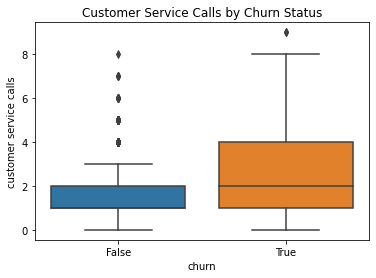

In [15]:
sns.boxplot(x='churn', y='customer service calls', data=df)
plt.title('Customer Service Calls by Churn Status')
plt.show()

Insight: Customers who churn tend to have more customer service calls, suggesting unresolved issues are a strong churn signal.

Churn vs International Plan

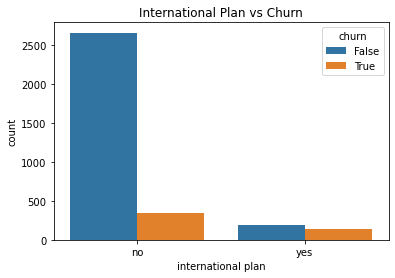

In [16]:
sns.countplot(x='international plan', hue='churn', data=df)
plt.title('International Plan vs Churn')
plt.show()

Insight

Customers who have an international plan churn at a higher rate than those without one, despite being a much smaller portion of the customer base.

Correlation Heatmap (Numeric Features)

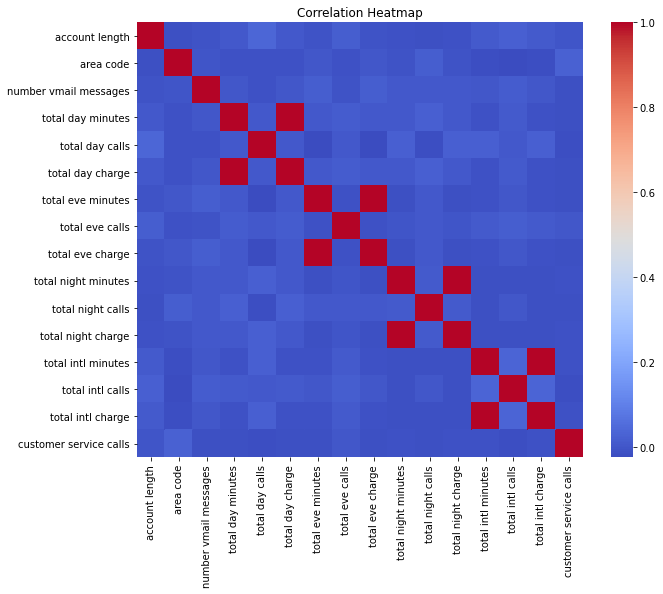

In [17]:
plt.figure(figsize=(10,8))
sns.heatmap(df.select_dtypes(include='number').corr(), cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

Insight: 

Strong correlations between minutes and charges indicate multicollinearity, which informs feature handling during modeling.

4. Data Preparation

Feature Selection

In [18]:
X = df.drop('churn', axis=1)
y = df['churn'].map({'yes': 1, 'no': 0})

Train-Test Split

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Preprocessing Pipeline

 - Scale numeric features

 - One-hot encode categorical features

In [23]:
num_features = X.select_dtypes(include='number').columns
cat_features = X.select_dtypes(include='object').columns


preprocessor = ColumnTransformer([
('num', StandardScaler(), num_features),
('cat', 'passthrough', cat_features)
])